In [2]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import matplotlib

import scipy as sp
from scipy import sparse
from scipy.fft import fft, ifft
from scipy.linalg import dft
from scipy.signal import find_peaks

from scipy.interpolate import interp1d

%load_ext sql
%sql sqlite:///Event.sqlite

The database is impoted and converted to a pandas dataframe, much better for data analysis in python and also better for exporting the data to numpy

In [3]:
cnx = sqlite3.connect(r'Event.sqlite')

# create the dataframe from a query
df = pd.read_sql_query("SELECT * FROM Event", cnx)

In [4]:
df

,ID,DateTimeEventTT,Satellite,Type1,Type2,Type3,Origin,DateTimeAdded
0,1,2020-01-01 15:17:59,1,OM,D,EXT,Thuillot,2020-12-13 12:52:55
1,2,2020-01-01 15:21:38,1,OM,D,INT,Thuillot,2020-12-13 12:52:55
2,3,2020-01-01 15:23:21,1,PA,D,EXT,Thuillot,2020-12-13 12:52:55
3,4,2020-01-01 15:27:01,1,PA,D,INT,Thuillot,2020-12-13 12:52:55
4,5,2020-01-01 17:32:48,1,OM,F,INT,Thuillot,2020-12-13 12:52:55
...,...,...,...,...,...,...,...,...
327786,381935,2016-12-31 14:17:00,2,PA,D,INT,Thuillot,2021-04-16 12:32:16
327787,381936,2016-12-31 14:18:53,2,OM,F,INT,Thuillot,2021-04-16 12:32:16
327788,381937,2016-12-31 14:23:15,2,OM,F,EXT,Thuillot,2021-04-16 12:32:16
327789,381938,2016-12-31 16:37:23,2,PA,F,INT,Thuillot,2021-04-16 12:32:16


In [5]:
df.Origin == 'PyMeeus'

0         False
1         False
2         False
3         False
4         False
          ...  
327786    False
327787    False
327788    False
327789    False
327790    False
Name: Origin, Length: 327791, dtype: bool

In [6]:
df.drop_duplicates()

,ID,DateTimeEventTT,Satellite,Type1,Type2,Type3,Origin,DateTimeAdded
0,1,2020-01-01 15:17:59,1,OM,D,EXT,Thuillot,2020-12-13 12:52:55
1,2,2020-01-01 15:21:38,1,OM,D,INT,Thuillot,2020-12-13 12:52:55
2,3,2020-01-01 15:23:21,1,PA,D,EXT,Thuillot,2020-12-13 12:52:55
3,4,2020-01-01 15:27:01,1,PA,D,INT,Thuillot,2020-12-13 12:52:55
4,5,2020-01-01 17:32:48,1,OM,F,INT,Thuillot,2020-12-13 12:52:55
...,...,...,...,...,...,...,...,...
327786,381935,2016-12-31 14:17:00,2,PA,D,INT,Thuillot,2021-04-16 12:32:16
327787,381936,2016-12-31 14:18:53,2,OM,F,INT,Thuillot,2021-04-16 12:32:16
327788,381937,2016-12-31 14:23:15,2,OM,F,EXT,Thuillot,2021-04-16 12:32:16
327789,381938,2016-12-31 16:37:23,2,PA,F,INT,Thuillot,2021-04-16 12:32:16


In [7]:
sql_cmd = """

WITH

PyMeeus AS
(
SELECT DateTimeEventTT, Satellite || Type1 || Type2 || Type3 AS Type, DateTimeEventTT, 
Satellite, Type1, Type2, Type3
FROM Event
WHERE ((Origin="PyMeeus") 
AND (Satellite == 1)  
AND (Type1 = "EC")
AND (Type2 = "D") 
AND (Type3 = "INT")
)),

Thuillot AS
(
SELECT DateTimeEventTT, Satellite || Type1 || Type2 || Type3 AS Type, DateTimeEventTT
FROM Event
WHERE ((Origin="Thuillot") 
AND (Satellite == 1)  
AND (Type1 = "EC")
AND (Type2 = "D") 
AND (Type3 = "INT")
))


SELECT p.DateTimeEventTT, p.Satellite, p.Type1, p.Type2, p.Type3, 
strftime('%s', p.DateTimeEventTT) - strftime('%s', t.DateTimeEventTT) AS deltaTime, 
MIN( ABS( strftime('%s', p.DateTimeEventTT) - strftime('%s', t.DateTimeEventTT) )) AS minDeltaTime
FROM (PyMeeus p INNER JOIN Thuillot t
ON p.Type = t.Type)
GROUP BY p.DateTimeEventTT
HAVING minDeltaTime <= 3600

"""

df = pd.read_sql_query(sql_cmd, cnx)

In [8]:
df

,DateTimeEventTT,Satellite,Type1,Type2,Type3,deltaTime,minDeltaTime
0,2016-01-01 15:42:26,1,EC,D,INT,8,8
1,2016-01-03 10:10:43,1,EC,D,INT,8,8
2,2016-01-05 04:39:06,1,EC,D,INT,7,7
3,2016-01-06 23:07:25,1,EC,D,INT,7,7
4,2016-01-08 17:35:48,1,EC,D,INT,7,7
...,...,...,...,...,...,...,...
587,2021-08-12 02:44:56,1,EC,D,INT,0,0
588,2021-08-13 21:13:29,1,EC,D,INT,0,0
589,2021-08-15 15:42:03,1,EC,D,INT,-1,1
590,2021-08-17 10:10:38,1,EC,D,INT,-1,1


# Eclipses

## IO

Text(0.5, 1.0, 'Variation in eclipse Time for satellite 1 - D')

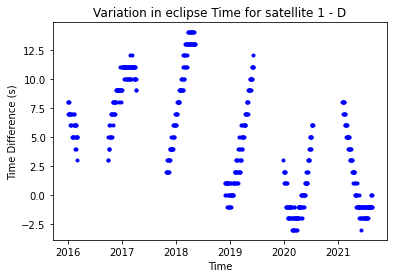

In [9]:
df_EC_INT_IO_INT= df[((df.Satellite == 1)&(df.Type1 == 'EC')&(df.Type2 == 'D')&(df.Type3 == 'INT'))]

df_EC_INT_IO_INT= df_EC_INT_IO_INT[[ 'DateTimeEventTT','deltaTime']]

dates_int = matplotlib.dates.date2num(df_EC_INT_IO_INT['DateTimeEventTT'].to_numpy())
matplotlib.pyplot.plot_date(dates_int, df_EC_INT_IO_INT['deltaTime'].to_numpy(), 'b.')

plt.ylabel('Time Difference (s)')
plt.xlabel('Time')
plt.title('Variation in eclipse Time for satellite 1 - D')

now it becomes necessaire to identify the portions of the s(t) function which is multiplied with the underlaying one in the time domain, in order to filter the effects of it out of the spectrum

In [10]:
datetime_array = df_EC_INT_IO_INT['DateTimeEventTT'].to_numpy()

In [11]:
df_unix_sec = pd.to_datetime(df_EC_INT_IO_INT['DateTimeEventTT']).astype(int)/ 10**9

#print(df_unix_sec)

first_sampling_time = df_unix_sec[0]

relative_sampling_time = df_unix_sec - first_sampling_time

print(relative_sampling_time)

0              0.0
1         152897.0
2         305800.0
3         458699.0
4         611602.0
          ...     
587    177073350.0
588    177226263.0
589    177379177.0
590    177532092.0
591    177685007.0
Name: DateTimeEventTT, Length: 592, dtype: float64


In [12]:
#now we must find samples that are more than three days apart, usually the orbital period is somewhat like 6 days, so everything is ok

samples_diff_vec = np.zeros(len(relative_sampling_time)-1)

for i in range (len(relative_sampling_time)-1):

    samples_diff_vec[i] = relative_sampling_time[i+1] - relative_sampling_time[i]

    
#print(samples_diff_vec)

hot_positions = samples_diff_vec > 160000*2

#print(hot_positions)

#identify positions limits for the s(t) function

s_limits = np.zeros(len(relative_sampling_time))


for i in range (len(hot_positions)):

    if(hot_positions[i]):
    
        s_limits[i] = relative_sampling_time[i]
        i = i+1
        s_limits[i] = relative_sampling_time[i]

#print(s_limits)

non_zero_indices = (np.nonzero(s_limits))[0]


print(non_zero_indices)

s_t = np.zeros(int(max(relative_sampling_time)))

i = 0

while i in range(np.size(non_zero_indices)-1):
    
    l_index = non_zero_indices[i]
    print(l_index)
    tmp = i+1
    i = i+1
    r_index = non_zero_indices[tmp]
    i = i+1

    print(r_index)
    
    print(int(relative_sampling_time[l_index]))
    print(int(relative_sampling_time[r_index]))
    print('---')
    
    for e in range(int(relative_sampling_time[l_index]), int(relative_sampling_time[r_index])):
        s_t[e] = 1.0
        #print(int(relative_sampling_time[l_index]))
        
        

#print(s_t)
 
print(np.sum(s_t))

s_t_sparse=sparse.csr_matrix(s_t)
    

[ 35  36 144 145 253 254 363 364 476 477]
35
36
5657556
23396389
---
144
145
39909512
57495582
---
253
254
74161487
91747693
---
363
364
108413767
125847202
---
476
477
142972483
160253240
---
87625301.0


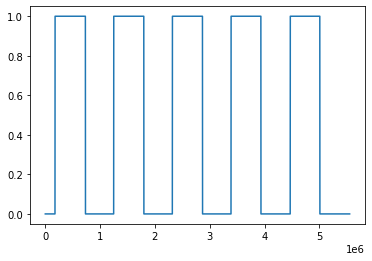

In [13]:
plt.plot(s_t[::32])

In [14]:
s_jump_spectrum = fft(s_t[::32])


print(s_jump_spectrum)

[2738290.            -0.j         -104026.55695002-39391.79077488j
 -102036.73493963-58452.17781543j ... -131273.22270492+89826.93403633j
 -102036.73493963+58452.17781543j -104026.55695002+39391.79077488j]


/home/vserra/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


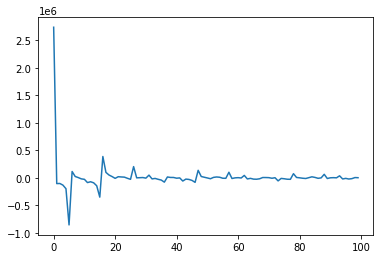

In [15]:
plt.plot(s_jump_spectrum[0:10**2])

In [16]:
#now we have to generate the remianing data from the eclipse difference time data

eclipse_diff_data = np.zeros(int(max(relative_sampling_time)))


time_diff_data_sparse = df_EC_INT_IO_INT['deltaTime'].to_numpy()


for i in range(len(relative_sampling_time)-1):
    
    timestamp = int(relative_sampling_time[i])
    
    eclipse_diff_data[timestamp] = time_diff_data_sparse[i]

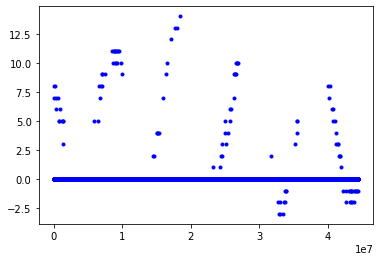

In [17]:
plt.plot(eclipse_diff_data[::4], 'b.')

In [18]:
#perform the FFT

#the frequencie we want to be able to see are 1y and 10y. The overall sampling time is 5 years, menaning that we
#need to at least extend the number of samples --> this is only possible by performing a downsampling first
#otherwise the vector will be too much for the memory of the machine

#we are measuring everything in seconds, we don't really need that precision, let's switch to hours instead,
#this will reduce the size of the data to 50 thousands points

n_samples_per_bin = 3600
binned_vec_len = int((len(eclipse_diff_data)/n_samples_per_bin))

print("Length of new vector : " + str(binned_vec_len) + " from : " + str(len(eclipse_diff_data)))

zeropad_initial = len(eclipse_diff_data) - n_samples_per_bin * binned_vec_len

zeropad_vec = np.zeros(zeropad_initial)

np.append(eclipse_diff_data, zeropad_vec)

binned_eclipse_data_hours = np.zeros(binned_vec_len)

for i in range(binned_vec_len):

    binned_eclipse_data_hours[i] = np.sum(eclipse_diff_data[i*n_samples_per_bin: (i+1)*n_samples_per_bin])

#eclipse_data_downsampled = eclipse_diff_data[::10]

#print(str(len(eclipse_data_downsampled))  + "samples, is a 5 years period")

#len_zero_trailer = int(len(eclipse_data_downsampled) * 6 / 5);

#zero_trailer = np.zeros(len_zero_trailer)

#np.append(eclipse_data_downsampled, zero_trailer)

#plt.plot(eclipse_data_downsampled)

#s_spectrum = fft(eclipse_diff_data)


#print(s_spectrum)

Length of new vector : 49356 from : 177685007


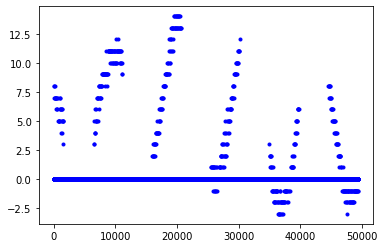

In [19]:
plt.plot(binned_eclipse_data_hours, 'b.')

In [20]:
s_spectrum = fft(binned_eclipse_data_hours)

/home/vserra/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


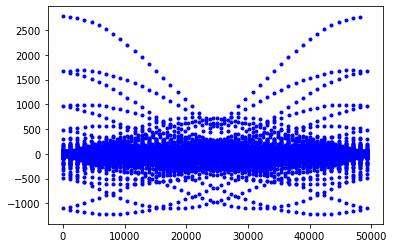

In [21]:
plt.plot(s_spectrum[:], 'b.')

In [22]:
#this is not a particularry good result, there are too many variables variating the spectrum, 
#hence too many harmonics
#we should filter it before we proceed

In [66]:
#let's begin with an interpolation, a simple cubic one

hours_linspace = np.linspace(0, len(binned_eclipse_data_hours)-1, len(binned_eclipse_data_hours))

idx = np.nonzero(binned_eclipse_data_hours)
interp = interp1d(hours_linspace[idx],binned_eclipse_data_hours[idx], kind = 'linear', fill_value="extrapolate")

print(interp)

eclipse_data_interp = interp(hours_linspace[:])

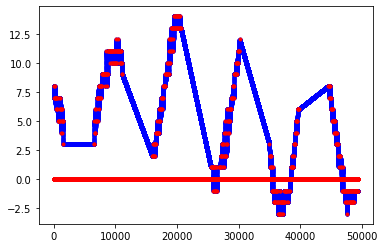

In [67]:
plt.plot(eclipse_data_interp, 'b.')
plt.plot(binned_eclipse_data_hours, 'r.')

In [68]:
#zero pad for higher resolutioin
zero_pad = np.zeros(10**7)
s_interp = fft(np.append(eclipse_data_interp, zero_pad))

/home/vserra/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


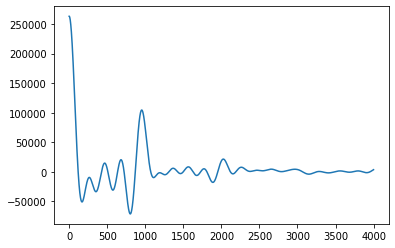

In [69]:
plt.plot(s_interp[0:4*10**2*10**1])

In [70]:
peaks, _ = find_peaks(np.abs(s_interp[:]), height=10**4)


print(peaks)

[     312      541      923     1199     1406     1615     1886     2025
 10047331 10047470 10047741 10047950 10048157 10048433 10048815 10049044]


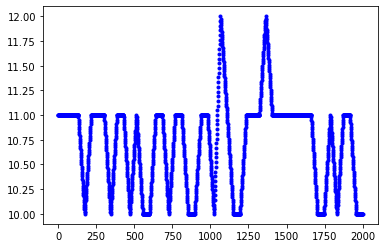

In [71]:
plt.plot(eclipse_data_interp[9000:11000], 'b.')

/home/vserra/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


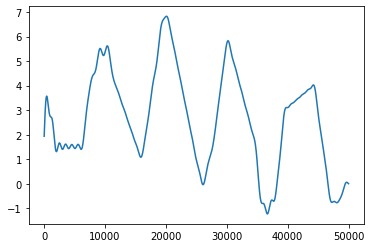

In [72]:
plt.plot(ifft(np.append(s_interp[0:10**4], zero_pad))[0:50*10**3])



In [73]:
np.append(s_t, zeropad_vec)

s_t_hrs = np.zeros(binned_vec_len)

print(binned_vec_len)

for i in range(binned_vec_len):

    s_t_hrs[i] = np.mean(s_t[i*n_samples_per_bin: (i+1)*n_samples_per_bin])

49356


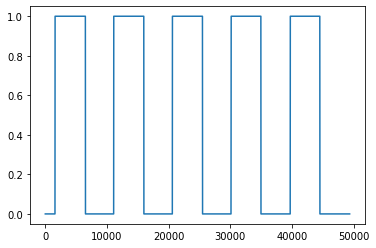

In [74]:
plt.plot(s_t_hrs)

In [75]:
cleaned_array = eclipse_data_interp * s_t_hrs

s_cleaned = fft(np.append(cleaned_array, zero_pad))

/home/vserra/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


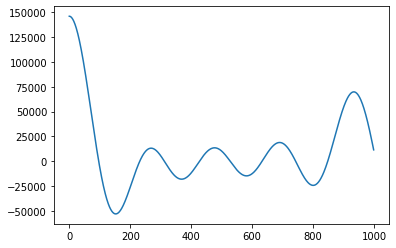

In [76]:
plt.plot(s_cleaned[0:10**3])

In [77]:
peaks, _ = find_peaks(np.abs(s_cleaned[:]), height=10**4)


print(peaks)

[     325      530      756     1029     1354     1985     3155     4111
     4282     5267     7376 10041980 10044089 10045074 10045245 10046201
 10047371 10048002 10048327 10048600 10048826 10049031]


In [58]:
#plt.plot(s_spectrum[::5])

#plt.plot(peaks, s_spectrum[peaks], "x")

In [60]:
#plt.plot(s_spectrum[::5])

plt.plot(peaks[:], s_spectrum[peaks[:]], "x")

IndexError: index 2008631 is out of bounds for axis 0 with size 49356

In [29]:
print(peaks[0: int(len(peaks)/2)])

[1162 1628 2324 2327 2447 2790 2898 3486 3489 3609 3732 3952 4060 4527
 4648 4771]


In [30]:
len(peaks)

32

In [31]:
#one year in seconds

y_in_sec = 3600*24*365.25
print(y_in_sec)

31557600.0


In [32]:
print(max(relative_sampling_time))

177685007.0


In [33]:
max(relative_sampling_time) / 5


35537001.4

In [34]:
y_in_sec / 5

6311520.0

In [35]:
y_in_sec / (5*5)

1262304.0

In [36]:
#the frequency will be measured in JULIAN years, hence let's begin with a test of that and then move on
#to the real fft of the data

#the samples are taken at 1 sec distance from one another

inteval_length_sec = max(relative_sampling_time) #length of the sampling interval in seconds

t_vec_sec = np.linspace(0,int(inteval_length_sec), int(inteval_length_sec)+1) 

#convert the interval to JULIAN years
y_in_sec = 31557600

#test it all with a sine function
freq_test = 1 #years
#y_test = np.sin(freq_test * 2 * np.pi * t_vec_sec / y_in_sec ) + np.sin(freq_test * 5 * 2 * np.pi * t_vec_sec / y_in_sec )



In [ ]:
#downsample fft
downsample_analysis = 4

#perform the fft
spectrum_test = np.fft.fft(eclipse_diff_data[::downsample_analysis])

N = s_spectrum.size #number of samples
T = 1/y_in_sec  #spacing between samples

#freq = np.linspace(0,T,N)

downsample_visualizatioin = 16

#plt.plot(freq[::downsample_visualizatioin*downsample_analysis], spectrum_test[::downsample_visualizatioin])

plt.plot(spectrum_test[::downsample_visualizatioin])

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter(y=np.abs(s_spectrum[::downsample_visualizatioin])))
fig.show()

In [ ]:
#plt.plot(y_test[::16])

In [ ]:
plt.plot(abs(spectrum_test[0:40]), '.')

In [ ]:
x = np.linspace(0, 1500, num = 1000)

y = np.sin(10*2*np.pi*x/1000) + np.sin(np.pi*x/1000)
#y = y + +np.sin(1/50*x)

In [ ]:
spt = np.fft.fft(y)

T = 1  # sampling interval 
N = y.size

# 1/T = frequency
f = np.linspace(0, 1 / T, N)

plt.plot(y)

In [ ]:
plt.plot((spt[0:20]), 'b.')

In [ ]:
plt.plot(f, spt)

In [ ]:
plt.plot(spt[0:20])

In [ ]:
y = np.append(y, np.zeros(1500))


In [ ]:
spt = np.fft.fft(y)
plt.plot(abs((spt[0:2000])))

In [ ]:
plt.plot(abs((spt[0:35*2])))